In [1]:
"""initial_districts = {
     'morumbi': [316,317,318,319],
     'jdPaulista': [74,75,76,77,78,79],
     'vilaMariana': [49,50,51,52,53,54,55,56,57]
}

initial_zones = [v for l in initial_districts.values() for v in l]"""

"initial_districts = {\n     'morumbi': [316,317,318,319],\n     'jdPaulista': [74,75,76,77,78,79],\n     'vilaMariana': [49,50,51,52,53,54,55,56,57]\n}\n\ninitial_zones = [v for l in initial_districts.values() for v in l]"

In [2]:
import pandas as pd

df = pd.read_csv('distritos.csv', sep=';')
df = df[df['cod_municipio'] == 36]

In [3]:
zones_to_dist = {}
for i,r in df.iterrows():
    zones_to_dist[r['zona']] = r['cod_distrito']

In [4]:
import os
os.chdir('../../src/')
from visualization.SIR_Plot import make_SIR_graph, make_beds_graph

In [5]:
os.chdir('models')
import simulate_pandemic as simp
from actions import costs, city_restrictions
from MCFS import mcts, treeNode
from CMDP import CovidState

Loading Graph...Done!


In [6]:
import numpy as np
from tqdm import tqdm

In [7]:
pop_matrix = simp.init_infection()
data = []
restrictions={'work':0, 'school': 0, 'home':0, 'neighbor':0}

days = 210

for day in tqdm(range(1, days+1)):
    # if less than 90% already recovered, break simulation
    if (pop_matrix[pop_matrix[:, 1] == -1].shape[0] > pop_matrix.shape[0]*.9):
        break

    pop_matrix = simp.spread_infection(pop_matrix, restrictions, day)
    pop_matrix = simp.lambda_leak_expose(pop_matrix, day)
    pop_matrix = simp.update_population(pop_matrix)

    data.append(pop_matrix[:, 0:2])


100%|████████████████████████████████████████████████████████████████████████████████| 210/210 [00:39<00:00,  5.33it/s]


In [71]:
nodes_in_region = defaultdict(int)

for n,d in simp.G.nodes(data=True):
    home_district = zones_to_dist[d['home']]
    nodes_in_region[home_district] +=1

In [122]:
from collections import defaultdict
districts_status = []

def node_to_district (node):
    return home_district
    
for d in data:
    d_status = defaultdict(int)
    
    infected = d[np.isin(d[:, 1], [1,2])][:, 0]
    for i in infected:
        home_zone = simp.G.nodes[i]['home']
        home_district = zones_to_dist[home_zone]
        d_status[home_district] += 1
    #for k,v in d_status.items():
    #    d_status[k] = v/nodes_in_region[k]
    districts_status.append(d_status)

In [123]:
import geopandas as gpd
gdf = gpd.read_file('../../notebooks/Geopandas SP/LAYER_DISTRITO/DEINFO_DISTRITO.shp')
#gdf['infected'] = gdf['COD_DIST'].apply(lambda x: districts_status[0][int(x)])

In [124]:
# Obtain population district -- Need to convert district names in shapes file to corresponding name in csv
from unidecode import unidecode
# List all names in csv file
names = np.unique([ s for s in df.distrito.array ])
name_conversion = {}

# For each district name in shapes file
for i,name in enumerate(gdf.NOME_DIST.array):
    # Find equivalent name in dist_df 
    d_name = '*** not found ***'
    for dist_name in names:
        if unidecode(dist_name).upper().replace('JARDIM','JD').replace('CIDADE','CID') == name:
            d_name = dist_name
            break
    name_conversion[name] = d_name
    
gdf['distrito'] = gdf.NOME_DIST.apply(lambda x: name_conversion[x])
gdf = pd.merge(gdf, df[['cod_distrito', 'distrito']].drop_duplicates(), on=['distrito'], how='left')

In [125]:
make_SIR_graph([d[:,1] for d in data])

,-1.0,0.0,1.0,2.0,3.0
0,0.0,55460.0,32.0,0.0,0.0
1,0.0,55458.0,31.0,3.0,0.0
2,0.0,55452.0,31.0,9.0,0.0
3,1.0,55442.0,39.0,10.0,0.0
4,2.0,55439.0,38.0,13.0,0.0
...,...,...,...,...,...
205,40608.0,14844.0,18.0,22.0,0.0
206,40612.0,14840.0,21.0,19.0,0.0
207,40615.0,14835.0,20.0,22.0,0.0
208,40618.0,14831.0,18.0,25.0,0.0


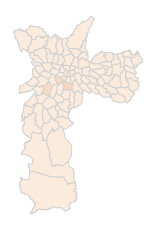

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt
cmap = sns.cm.rocket_r

fig, ax = plt.subplots()

gdf['infected'] = gdf.cod_distrito.apply(lambda x: districts_status[0][x])
gdf.plot(ax=ax, column='infected', cmap=cmap, vmin=0, vmax = 200, legend=False, legend_kwds={'shrink': 0.7}, 
         edgecolor='lightgray')

fig.patch.set_visible(False)
ax.axis('off')
plt.savefig('low_start_day0.pdf', bbox_inches = 'tight', pad_inches = 0)

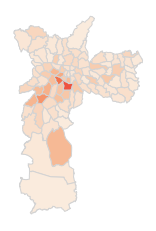

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt
cmap = sns.cm.rocket_r

fig, ax = plt.subplots()

gdf['infected'] = gdf.cod_distrito.apply(lambda x: districts_status[30][x])
gdf.plot(ax=ax, column='infected', cmap=cmap,  vmin=0, vmax = 200, legend=False, legend_kwds={'shrink': 0.7},
        edgecolor='lightgray')

fig.patch.set_visible(False)
ax.axis('off')
plt.savefig('low_start_day30.pdf', bbox_inches = 'tight', pad_inches = 0)

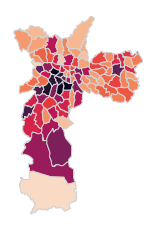

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt
cmap = sns.cm.rocket_r

fig, ax = plt.subplots()

gdf['infected'] = gdf.cod_distrito.apply(lambda x: districts_status[60][x])
gdf.plot(ax=ax, column='infected', cmap=cmap,  vmin=0, vmax = 200, legend=False, legend_kwds={'shrink': 0.7},
        edgecolor='lightgray')

fig.patch.set_visible(False)
ax.axis('off')
plt.savefig('low_start_day60.pdf', bbox_inches = 'tight', pad_inches = 0)

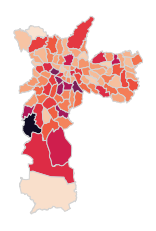

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt
cmap = sns.cm.rocket_r

fig, ax = plt.subplots()

gdf['infected'] = gdf.cod_distrito.apply(lambda x: districts_status[90][x])
gdf.plot(ax=ax, column='infected', cmap=cmap, vmin=0, vmax = 200, legend=False, legend_kwds={'shrink': 0.7},
        edgecolor='lightgray')

fig.patch.set_visible(False)
ax.axis('off')
plt.savefig('low_start_day90.pdf', bbox_inches = 'tight', pad_inches = 0)

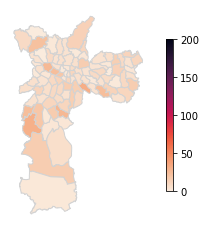

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt
cmap = sns.cm.rocket_r

fig, ax = plt.subplots()

gdf['infected'] = gdf.cod_distrito.apply(lambda x: districts_status[120][x])
gdf.plot(ax=ax, column='infected', cmap=cmap, vmin=0, vmax = 200, legend=True, legend_kwds={'shrink': 0.7},
        edgecolor='lightgray')

fig.patch.set_visible(False)
ax.axis('off')
plt.savefig('low_start_day120.pdf', bbox_inches = 'tight', pad_inches = 0)